In [66]:
params = {
    # Global parameters
    "T_target": 298,
    "t_span": (1e-10, 1e1),
    "t0": 1e-2,
    "A_in": 24.8378,
    "MobileTS": True,
    "N_Gas": 8,
    "T_min": 200,
    "T_max": 600,

    # Molecule 1 (O2, linear)
    "molecule1_molecule_type": "linear",
    "molecule1_p": 1,
    "molecule1_m": 31.98983,
    "molecule1_Edes": 0.5634,
    "molecule1_sigma": 2.0,
    "molecule1_theta_rot_linear": 2.14799,

    # Molecule 2 (H2O, nonlinear)
    "molecule2_molecule_type": "nonlinear",
    "molecule2_p": 1,
    "molecule2_m": 18.01056,
    "molecule2_Edes": 0.3140,
    "molecule2_sigma": 2.0,
    "molecule2_theta_rot_A": 40.16456,
    "molecule2_theta_rot_B": 20.59791,
    "molecule2_theta_rot_C": 13.61541,

    # Molecule 3 (CO, linear)
    "molecule3_molecule_type": "linear",
    "molecule3_p": 1,
    "molecule3_m": 27.99491,
    "molecule3_Edes": 0.1848,
    "molecule3_sigma": 1.0,
    "molecule3_theta_rot_linear": 2.81941,

    # Molecule 4 (CO2, linear)
    "molecule4_molecule_type": "linear",
    "molecule4_p": 1,
    "molecule4_m": 43.98983,
    "molecule4_Edes": 0.1837,
    "molecule4_sigma": 2.0,
    "molecule4_theta_rot_linear": 0.56877,

    # Molecule 5 (NO, linear)
    "molecule5_molecule_type": "linear",
    "molecule5_p": 1,
    "molecule5_m": 29.99799,
    "molecule5_Edes": 0.5383,
    "molecule5_sigma": 1.0,
    "molecule5_theta_rot_linear": 2.51735,

    # Molecule 6 (NO2, nonlinear)
    "molecule6_molecule_type": "nonlinear",
    "molecule6_p": 1,
    "molecule6_m": 45.99290,
    "molecule6_Edes": 1.4108,
    "molecule6_sigma": 2.0,
    "molecule6_theta_rot_A": 12.23047,
    "molecule6_theta_rot_B": 0.63849,
    "molecule6_theta_rot_C": 0.60681,

    # Molecule 7 (SO2, nonlinear)
    "molecule7_molecule_type": "nonlinear",
    "molecule7_p": 1,
    "molecule7_m": 63.96190,
    "molecule7_Edes": 0.8287,
    "molecule7_sigma": 2.0,
    "molecule7_theta_rot_A": 2.87333,
    "molecule7_theta_rot_B": 0.50474,
    "molecule7_theta_rot_C": 0.42932,

    # Molecule 8 (SO3, nonlinear)
    "molecule8_molecule_type": "nonlinear",
    "molecule8_p": 1,
    "molecule8_m": 79.95682,
    "molecule8_Edes": 0.9815,
    "molecule8_sigma": 6.0,
    "molecule8_theta_rot_A": 0.50468,
    "molecule8_theta_rot_B": 0.50468,
    "molecule8_theta_rot_C": 0.25234,
}

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Physical constants
kB = 1.380649e-23   # Boltzmann constant (J/K)
h = 6.62607015e-34  # Planck constant (J·s)

rgb_list = [
    (212/255,  67/255,  70/255 ),  # (212, 67, 70)
    (227/255, 132/255, 134/255 ),  # (227, 132, 134)
    (255/255, 185/255,  63/255 ),  # (255, 185, 63)
    (255/255, 215/255, 147/255 ),  # (255, 215, 147)
    ( 24/255, 126/255, 239/255 ),  # (24, 126, 239)
    (173/255, 197/255, 241/255 ),  # (173, 197, 241)
    (108/255, 193/255, 164/255 ),  # (108, 193, 164)
    (163/255, 216/255, 198/255 ),  # (163, 216, 198)
]

def compute_rate_constants(params, i, T):
    """
    Calculate k_ads and k_des at temperature T for molecule i.
    """
    prefix = f"molecule{i}_"
    p_bar       = params[prefix + "p"]
    m_amu       = params[prefix + "m"]
    Edes_eV     = params[prefix + "Edes"]
    sigma       = params[prefix + "sigma"]
    molecule_type = params[prefix + "molecule_type"]

    p = p_bar * 1e5
    A = params["A_in"] * 1e-20
    m_kg = m_amu * 1.660539e-27
    Edes_J = Edes_eV * 1.602176565e-19

    mobile_ts = params.get("MobileTS")
    if isinstance(mobile_ts, str):
        mobile_ts = mobile_ts.strip().lower() == "true"

    if mobile_ts:
        k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T)
        k_des = (kB * T**2) / h**3 * (2.0 * A * np.pi * m_kg * kB) * np.exp(-Edes_J/(kB*T))
    else:
        if molecule_type == "linear":
            theta_rot = params[prefix + "theta_rot_linear"]
            k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T) * (sigma * theta_rot / T)
            k_des = (kB * T**3) / h**3 * (2.0 * A * np.pi * m_kg * kB/(sigma * theta_rot)) * np.exp(-Edes_J/(kB*T))
        elif molecule_type == "nonlinear":
            theta_rot_A = params[prefix + "theta_rot_A"]
            theta_rot_B = params[prefix + "theta_rot_B"]
            theta_rot_C = params[prefix + "theta_rot_C"]
            theta_rot_product = theta_rot_A * theta_rot_B * theta_rot_C
            k_ads = p * A / np.sqrt(2.0 * np.pi * m_kg * kB * T) * (sigma / np.sqrt(np.pi)) * np.sqrt(theta_rot_product/T**3)
            k_des = (kB * T**3.5) / h**3 * (2.0 * A * np.pi**1.5 * m_kg * kB/(sigma * np.sqrt(theta_rot_product))) * np.exp(-Edes_J/(kB*T))
        else:
            raise ValueError(f"Unknown molecule type: {molecule_type}")
    return k_ads, k_des

def main_single(params):
    """
    theta_a(t) = [k_ads/(k_ads+k_des)]·(1 - exp( - (k_ads+k_des)*t ))·theta_a0
    theta_a(t) = theta_a(t0)·exp( - k_des*(t-t0) )
    theta* = theta_a0 - theta_a
    """
    T_target = params["T_target"]
    t_span = params["t_span"]
    t0 = params["t0"]
    c_a0 = 1.0
    N = params["N_Gas"]

    for i in range(1, N+1):
        k_ads, k_des = compute_rate_constants(params, i, T_target)

        t_ads = np.logspace(np.log10(t_span[0]), np.log10(t0), 2000)
        c_a_ads = (k_ads/(k_ads+k_des)) * (1 - np.exp(-(k_ads+k_des)*t_ads)) * c_a0
        c_star_ads = c_a0 - c_a_ads


        c_a_t0 = c_a_ads[-1]
        t_des = np.logspace(np.log10(t0), np.log10(t_span[1]), 500)
        c_a_des = c_a_t0 * np.exp(-k_des*(t_des - t0))
        c_star_des = c_a0 - c_a_des
        print(f"The recovery time of molecule {i} at {T_target} K")
        print(f"{1.0 / k_des:.4e} s")

        plt.figure(figsize=(8,6))
        plt.plot(t_ads, c_a_ads, label="Adsorbed gas", color=rgb_list[i-1])
        plt.plot(t_des, c_a_des, color=rgb_list[i-1])
        plt.plot(t_ads, c_star_ads, label="Active sites", linestyle="--", color='grey')
        plt.plot(t_des, c_star_des, linestyle="--", color='grey')
        plt.xscale("log")
        plt.xlabel("Time (s)", fontsize=18)
        plt.ylabel("Coverage", fontsize=18)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.title(f"Molecule {i} - {params[f'molecule{i}_molecule_type']}")
        plt.grid()
        #plt.legend()
        plt.show()

def main_Tdep(params):
    """
    - tau = 1/k_des
    - K_eq = k_ads/k_des
    - theta_eq = theta_a0/(1 + 1/K_eq)
    """
    T_min = params["T_min"]
    T_max = params["T_max"]
    T_range = np.linspace(T_min, T_max, 100)
    N = params["N_Gas"]
    c_a0 = 1.0

    tau_vals = np.zeros((N, len(T_range)))
    Keq_vals = np.zeros((N, len(T_range)))
    c_a_eq_vals = np.zeros((N, len(T_range)))

    for i in range(1, N+1):
        for j, T in enumerate(T_range):
            k_ads, k_des = compute_rate_constants(params, i, T)
            tau_vals[i-1, j] = 1.0 / k_des
            Keq_vals[i-1, j] = k_ads / k_des
            c_a_eq_vals[i-1, j] = c_a0 / (1.0 + 1.0/Keq_vals[i-1, j])

    plt.figure(figsize=(8,6))
    for i in range(N):
        plt.plot(T_range, tau_vals[i, :], label=f"Molecule {i+1}", color=rgb_list[i])
    plt.yscale("log")
    plt.xlabel("Temperature (K)", fontsize=18)
    plt.ylabel("\u03C4"" (s)", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i in range(N):
        plt.plot(T_range, Keq_vals[i, :], label=f"Molecule {i+1}", color=rgb_list[i])
    plt.yscale("log")
    plt.xlabel("Temperature (K)", fontsize=18)
    plt.ylabel(r"$K_{eq}$", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, which="both")
    #plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i in range(N):
        plt.plot(T_range, c_a_eq_vals[i, :], label=f"Molecule {i+1}", color=rgb_list[i])
    plt.xlabel("Temperature (K)", fontsize=18)
    plt.ylabel(r"$\theta_{eq}$", fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    #plt.legend()
    plt.show()

The recovery time of molecule 1 at 298 K
6.9958e-07 s


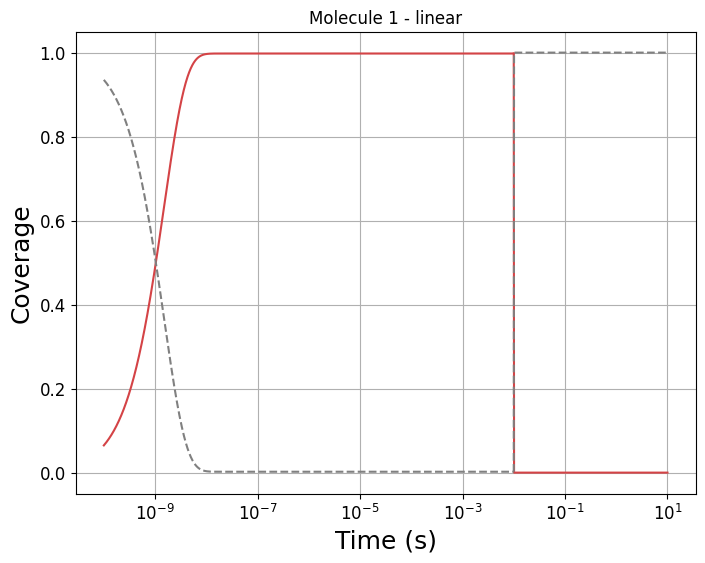

The recovery time of molecule 2 at 298 K
7.5244e-11 s


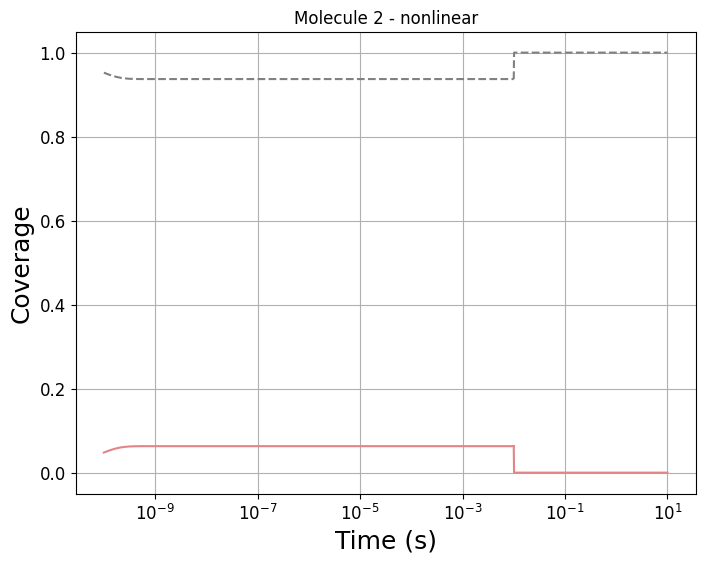

The recovery time of molecule 3 at 298 K
3.1615e-13 s


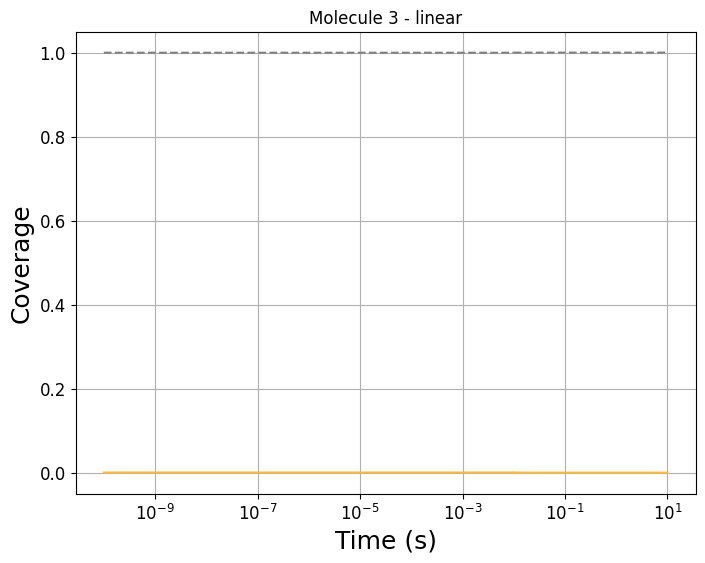

The recovery time of molecule 4 at 298 K
1.9276e-13 s


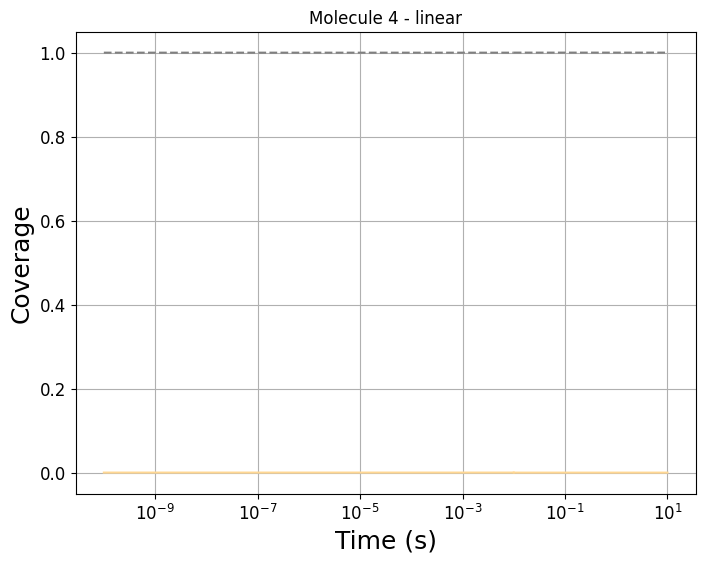

The recovery time of molecule 5 at 298 K
2.8072e-07 s


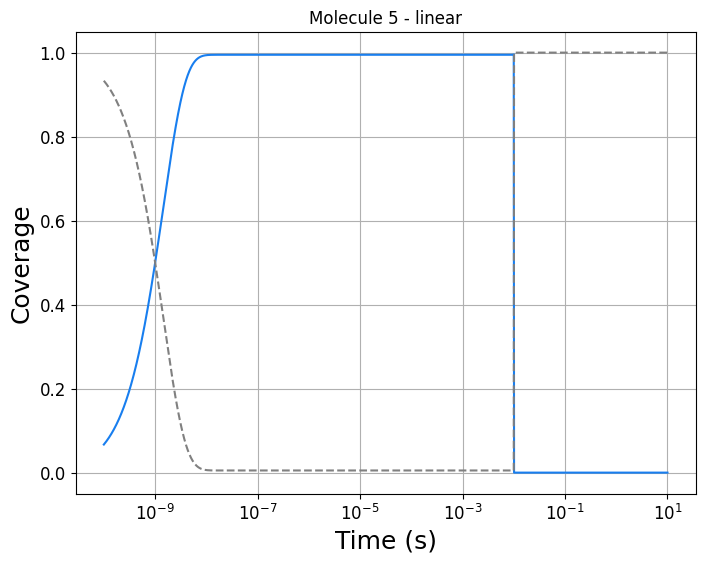

The recovery time of molecule 6 at 298 K
1.0433e+08 s


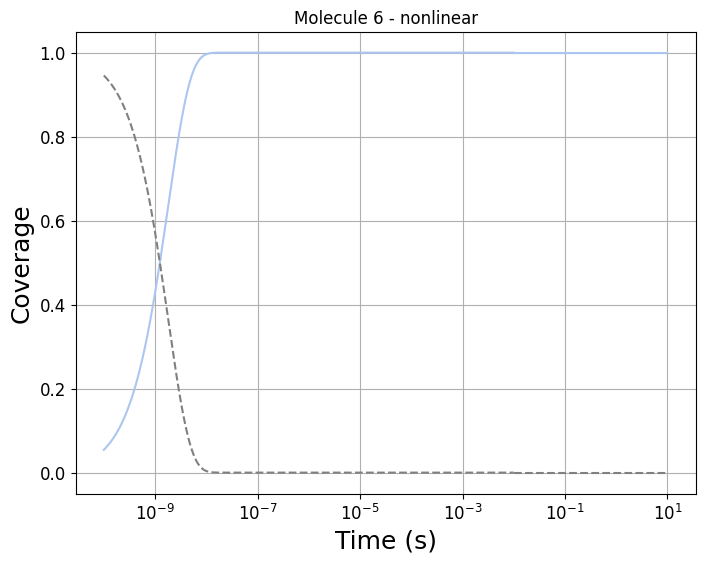

The recovery time of molecule 7 at 298 K
1.0732e-02 s


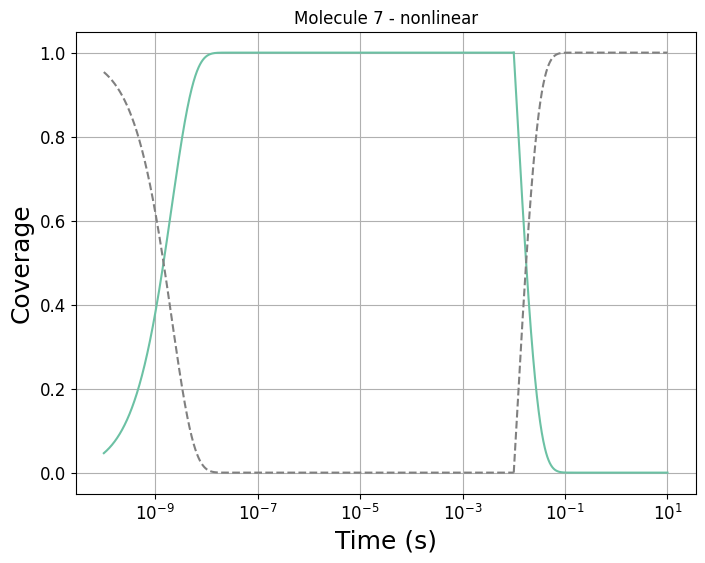

The recovery time of molecule 8 at 298 K
3.2954e+00 s


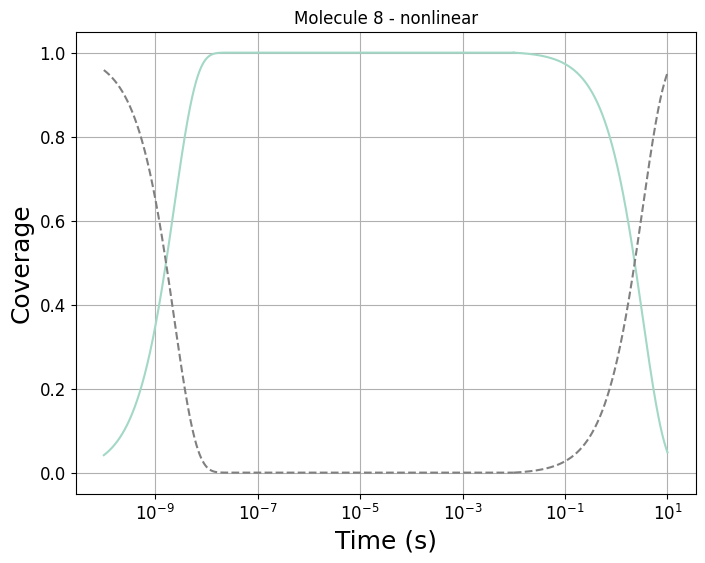

In [68]:
if __name__ == "__main__":
  main_single(params)

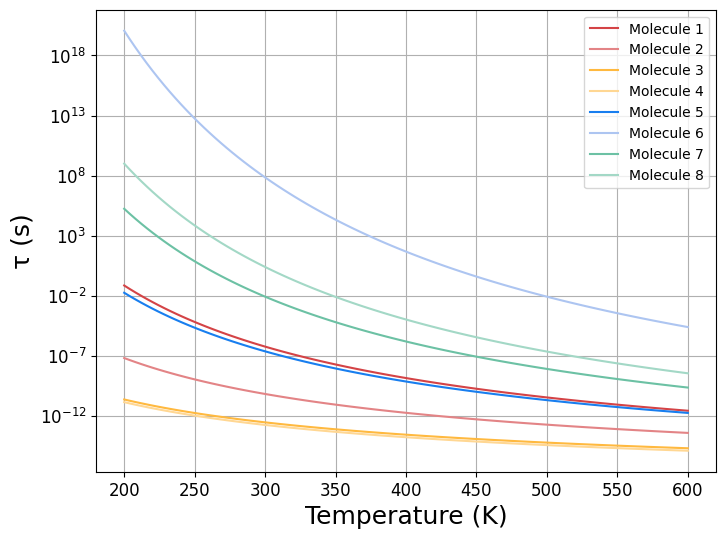

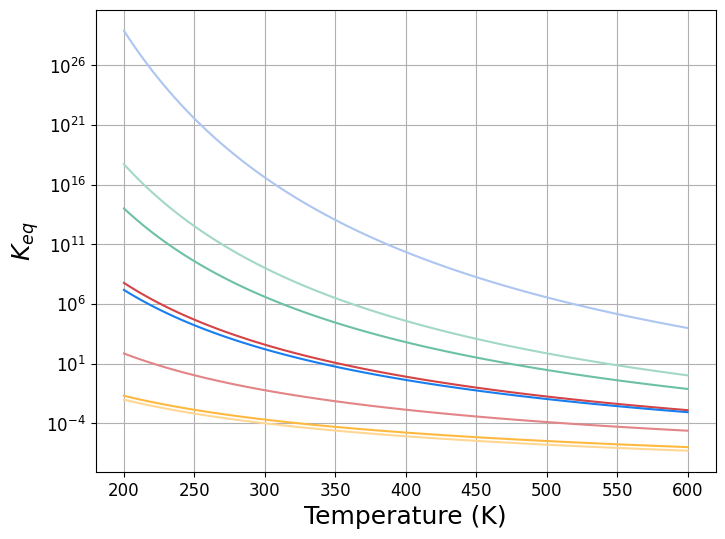

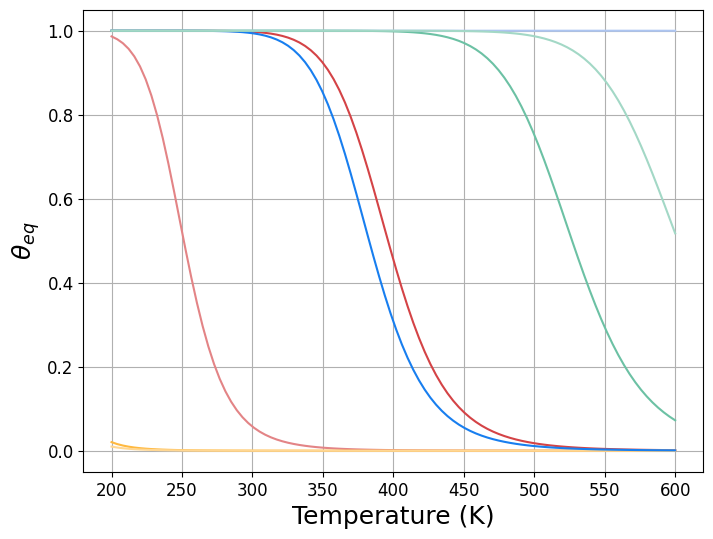

In [69]:
if __name__ == "__main__":
  main_Tdep(params)